### Subgraphs

In these tutorial we are going to implement the subgraphs. Which means instead of passing the nodes we will pass the graphs to it. 

Importing the Required Libraries

In [1]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph,START,END
from typing import TypedDict
from operator import add

Creating the First Sub Graph with its state and compile

In [6]:
class GenerateReportAnalysis(TypedDict):
    report: str
    text: str
    
class GenerateReportAnalysisOutput(TypedDict):
    analysis: str

In [7]:
def node_generate_report(state: GenerateReportAnalysis) -> GenerateReportAnalysisOutput:
    return {
        "analysis": f"This is an analysis of the report: {state['report']}"
    }

In [8]:
graph_1 = StateGraph(GenerateReportAnalysis, output_schema=GenerateReportAnalysisOutput)
graph_1.add_node("generate_report", node_generate_report)

graph_1.add_edge(START, "generate_report")
graph_1.add_edge("generate_report", END)

generate_report_subgraph = graph_1.compile()

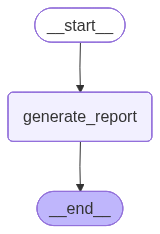

In [9]:
from IPython.display import display, Image

display(Image(generate_report_subgraph.get_graph().draw_mermaid_png()))

Creating the Second Graph with state and Nodes

In [10]:
class ReportSummarization(TypedDict):
    text: str
    report: str


class ReportSummarizationOutput(TypedDict):
    summary: str

In [11]:
def generate_report_summary(state: ReportSummarization) -> ReportSummarizationOutput:
    return {"summary": f"This is a summary of the report: {state['report']}"}

In [12]:
graph_2=StateGraph(ReportSummarization, output_schema=ReportSummarizationOutput)
graph_2.add_node("generate_summary", generate_report_summary)
graph_2.add_edge(START, "generate_summary")
graph_2.add_edge("generate_summary", END)
generate_summary_subgraph = graph_2.compile()

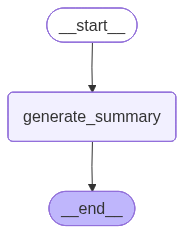

In [13]:
display(Image(generate_summary_subgraph.get_graph().draw_mermaid_png()))

Creating Whole Graph in a new graph with combining the multiple subgraph

In [14]:
class Reports(TypedDict):
    report: str
    text: str
    summary: str
    analysis: str

In [20]:
def get_reports(state: Reports) -> Reports:
    return {
        "report": "Why to investigate about the langgraph library?"
    }

In [24]:
from langgraph.runtime import Runtime

def send_to_mail(state: Reports,runtime:Runtime) -> Reports:
    if runtime.stream_writer:
        runtime.stream_writer(f"Sending report analysis to mail: {state['analysis']}\n")
    return state

Creating the parent graph for adding the subgraph as a node. We can also have call another graph in the node.

In [25]:
graph = StateGraph(Reports)
graph.add_node("get_reports", get_reports)
graph.add_node("generate_summary_subgraph", generate_summary_subgraph)
graph.add_node("generate_report_subgraph", generate_report_subgraph)
graph.add_node("send_to_mail", send_to_mail)

graph.add_edge(START, "get_reports")
graph.add_edge("get_reports", "generate_summary_subgraph")
graph.add_edge("get_reports", "generate_report_subgraph")
graph.add_edge(
    ["generate_summary_subgraph", "generate_report_subgraph"], "send_to_mail"
)
graph.add_edge("send_to_mail", END)


compile_graph = graph.compile()

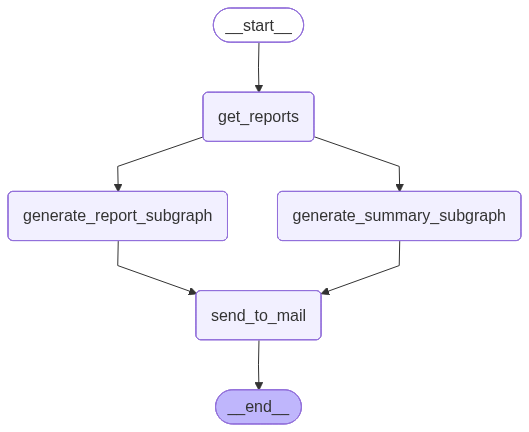

In [26]:
display(Image(compile_graph.get_graph().draw_mermaid_png()))

Invoking the Graph

In [28]:
for chunk in compile_graph.stream({"text": "The langgraph library is a powerful tool for building stateful applications using language"},stream_mode=["custom","updates"],subgraphs=True):
    print(chunk)

((), 'updates', {'get_reports': {'report': 'Why to investigate about the langgraph library?'}})
(('generate_report_subgraph:47a9083e-ed3d-2b73-1ba9-fdf585993118',), 'updates', {'generate_report': {'analysis': 'This is an analysis of the report: Why to investigate about the langgraph library?'}})
((), 'updates', {'generate_report_subgraph': {'analysis': 'This is an analysis of the report: Why to investigate about the langgraph library?'}})
(('generate_summary_subgraph:1f41c556-3434-3ba5-1220-0f90b45309f5',), 'updates', {'generate_summary': {'summary': 'This is a summary of the report: Why to investigate about the langgraph library?'}})
((), 'updates', {'generate_summary_subgraph': {'summary': 'This is a summary of the report: Why to investigate about the langgraph library?'}})
((), 'custom', 'Sending report analysis to mail: This is an analysis of the report: Why to investigate about the langgraph library?\n')
((), 'updates', {'send_to_mail': {'report': 'Why to investigate about the lan

these is how we can add the subgraph as the node with streaming their values support